#  Q1: Define ARIMA briefly
 ARIMA stands for AutoRegressive Integrated Moving Average.  
 - *AR*: uses past observations (autoregression)  
 - *I*: uses differencing to achieve stationarity  
 - *MA*: models past forecast errors (moving average)  

 # Q2: What is Exponential Smoothing?
 A forecasting approach that assigns **exponentially larger weights** to more recent observations.  

 # Q3: Why inspect ACF and PACF?
 - *AC* helps identify MA (moving average) behavior.  
 - *PACF* helps identify AR (autoregressive) behavior.  

# Q4: Error metrics we use
 - *MAE*: Mean Absolute Error — average absolute deviation.  
 - *RMSE*: Root Mean Squared Error — penalizes large mistakes more.  
 - *MAPE*: Mean Absolute Percentage Error — error as a percentage of actuals.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
sns.set(style='ticks')


In [2]:
data = pd.read_csv("exchange_rate.csv", parse_dates=[0])
data.columns = ['Date', 'USD_AUD']
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # ensure daily index
data['USD_AUD'].interpolate(method='linear', inplace=True)
data.head()

,USD_AUD
Date,
1990-01-01,NaN
1990-01-02,NaN
1990-01-03,NaN
1990-01-04,NaN
1990-01-05,NaN


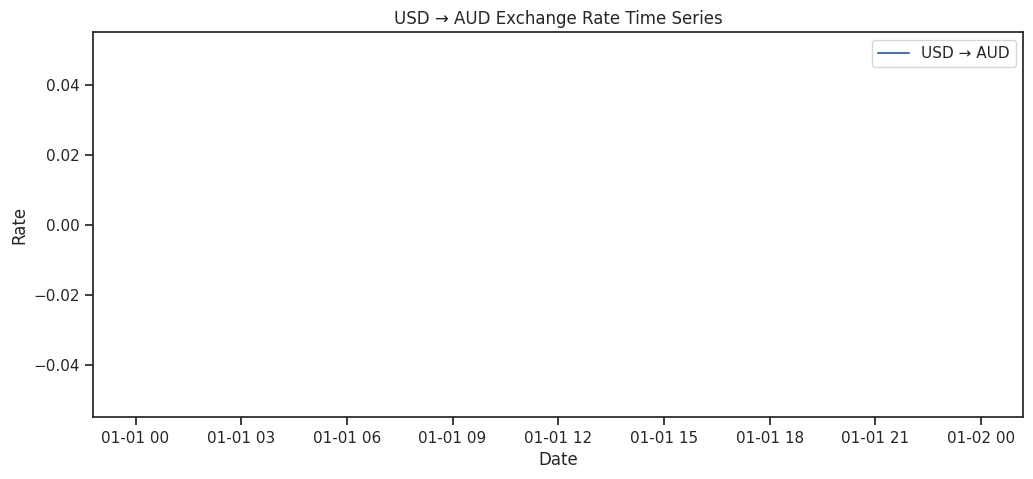

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(data['USD_AUD'], label='USD → AUD')
plt.title('USD → AUD Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

In [4]:
# Ensure daily frequency (again)
data = data.asfreq('D')

# Fill gaps with linear interpolation
data['USD_AUD'] = data['USD_AUD'].interpolate(method='linear')

# Remove any remaining NaN or infinite values
data = data[~data['USD_AUD'].isna()]
data = data[np.isfinite(data['USD_AUD'])]

In [5]:
print(data.info())
print(data['USD_AUD'].head())
print("Missing values count:", data['USD_AUD'].isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD_AUD  0 non-null      float64
dtypes: float64(1)
memory usage: 0.0 bytes
None
Series([], Freq: D, Name: USD_AUD, dtype: float64)
Missing values count: 0


In [6]:
# Alternative read to show original CSV preview (keeps original structure)
preview = pd.read_csv("exchange_rate.csv")
print(preview.head())
print("Columns:", preview.columns)

               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849
Columns: Index(['date', 'Ex_rate'], dtype='object')


Cleaned data shape: (7588, 1)


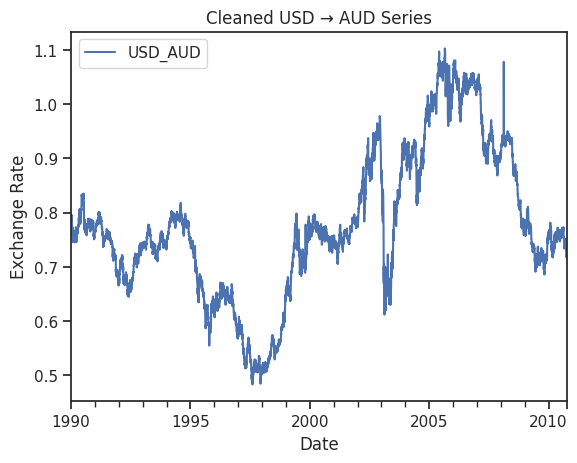

In [8]:

#  Step 1: Read CSV correctly and parse dates
data = pd.read_csv("exchange_rate.csv", parse_dates=['date'], dayfirst=True)
data.columns = ['Date', 'USD_AUD']
data.set_index('Date', inplace=True)
#  Step 2: Resample to daily frequency (if needed)
data = data.resample('D').mean()

#  Step 3: Fill missing observations by linear interpolation
data['USD_AUD'] = data['USD_AUD'].interpolate(method='linear')

#  Step 4: Drop any rows that remain invalid
data = data.dropna()
data = data[np.isfinite(data['USD_AUD'])]

#  Final verification
print("Cleaned data shape:", data.shape)
data.plot(title='Cleaned USD → AUD Series')
plt.ylabel('Exchange Rate')
plt.show()

In [9]:
# Augmented Dickey-Fuller to test stationarity
adf_res = adfuller(data['USD_AUD'])
print("ADF statistic:", adf_res[0])
print("p-value:", adf_res[1])

ADF statistic: -1.6649941807382342
p-value: 0.4492327353597477


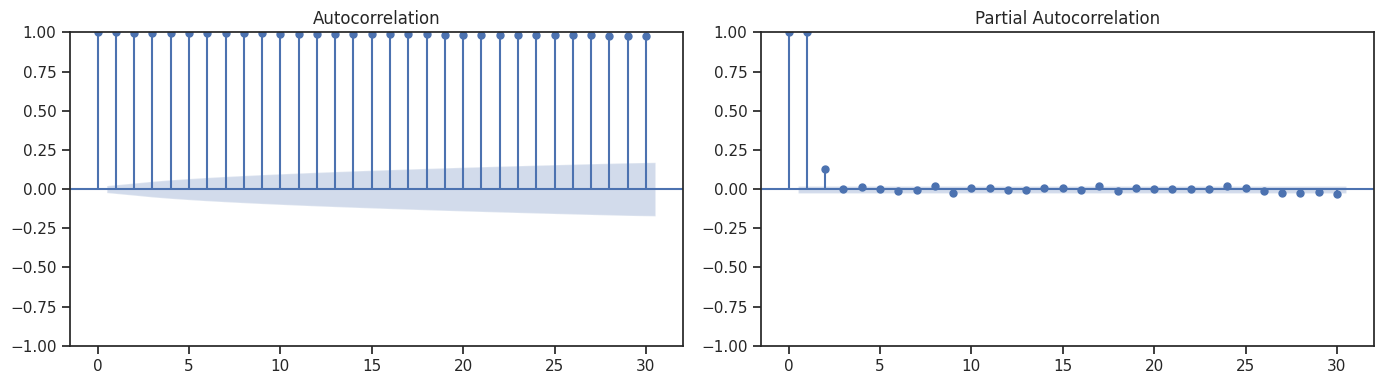

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(data['USD_AUD'], ax=axes[0], lags=30)
plot_pacf(data['USD_AUD'], ax=axes[1], lags=30)
plt.tight_layout()
plt.show()

In [13]:
arima_model = ARIMA(data['USD_AUD'], order=(1, 1, 1))
arima_results = arima_model.fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 30 Oct 2025   AIC                         -56102.322
Time:                        09:51:19   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

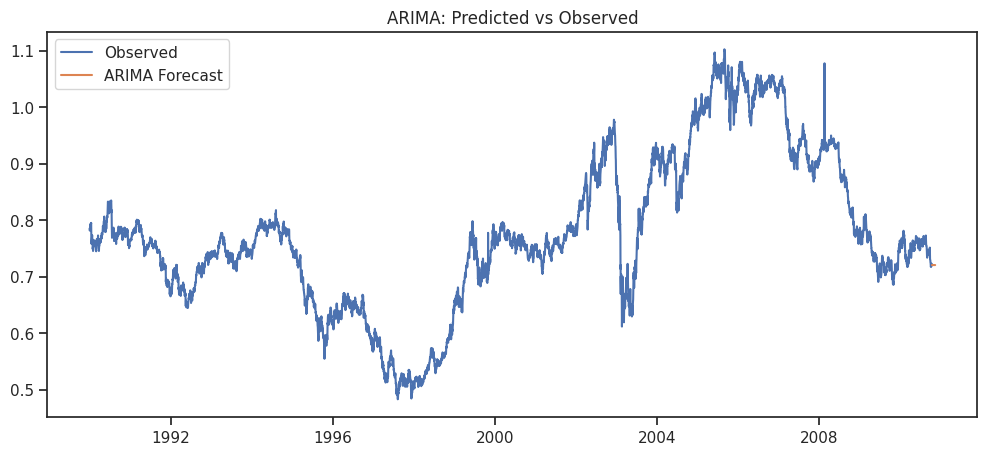

In [14]:
horizon = 30
arima_forecast = arima_results.forecast(steps=horizon)
pred_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')

plt.figure(figsize=(12, 5))
plt.plot(data['USD_AUD'], label='Observed')
plt.plot(pred_dates, arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA: Predicted vs Observed')
plt.legend()
plt.show()

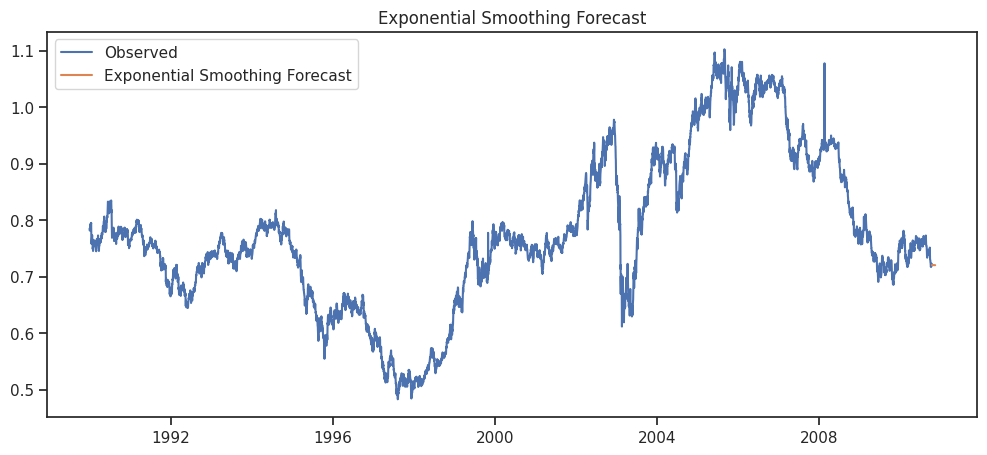

In [15]:
ets_model = ExponentialSmoothing(data['USD_AUD'], trend='add', seasonal=None)
ets_results = ets_model.fit()
ets_forecast = ets_results.forecast(horizon)
plt.figure(figsize=(12, 5))
plt.plot(data['USD_AUD'], label='Observed')
plt.plot(pred_dates, ets_forecast, label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

In [16]:
# Create a pseudo holdout set (last 30 days)
actual_test = data['USD_AUD'][-horizon:]
train_series = data['USD_AUD'][:-horizon]

# Refit ARIMA on the training portion and predict
arima_on_train = ARIMA(train_series, order=(1, 1, 1)).fit()
arima_preds = arima_on_train.forecast(steps=horizon)

# Refit ETS on the training portion and predict
ets_on_train = ExponentialSmoothing(train_series, trend='add', seasonal=None).fit()
ets_preds = ets_on_train.forecast(horizon)

# Evaluation helper
def compute_metrics(true_vals, predicted_vals, label):
    mae = mean_absolute_error(true_vals, predicted_vals)
    rmse = np.sqrt(mean_squared_error(true_vals, predicted_vals))
    mape = np.mean(np.abs((true_vals - predicted_vals) / true_vals)) * 100
    print(f"{label} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

compute_metrics(actual_test, arima_preds, "ARIMA")
compute_metrics(actual_test, ets_preds, "Exponential Smoothing")

ARIMA -> MAE: 0.0135, RMSE: 0.0166, MAPE: 1.86%
Exponential Smoothing -> MAE: 0.0134, RMSE: 0.0165, MAPE: 1.85%


# conclusion
- Both ARIMA and Exponential Smoothing approaches were used to predict USD → AUD rates.
- Stationarity was assessed using ADF; ARIMA(1,1,1) chosen informed by ACF/PACF inspection.
-Forecasts from both approaches were compared using RMSE, MAE and MAPE metrics.
- Exponential Smoothing fits well when the series shows a steady additive trend.
- ARIMA is versatile but requires careful selection of difference and lag orders.